In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px
import os
import plotly.graph_objects as go

In [10]:
# --- 1. Load the Dataset ---
try:
    df = pd.read_csv('fpkm_counts_with_annotations.csv')
    print("Successfully loaded the dataset.")
except FileNotFoundError:
    print("Error: 'fpkm_counts_with_annotations.csv' not found.")
    print("Please make sure the CSV file is in the same folder as this script.")
    exit()

# --- 2. Filter the Data based on annotations---
filtered_df = df #.dropna(subset=['JGI_annotation', 'KEGG_annotation'], how='all').copy()
print(f"Working with {len(filtered_df)} genes that have annotations.")


# --- 3. Define Sample Groups ---
groups = {
    'EBY': ['EBY_1', 'EBY_2', 'EBY_3'],
    'GNSR': ['EBY-GNSR_1', 'EBY-GNSR_2'],
    'GNHR': ['EBY-GNHR_1', 'EBY-GNHR_2', 'EBY-GNHR_3'],
    'GNUR': ['EBY-GNUR_1', 'EBY-GNUR_2', 'EBY-GNUR_3']
}


# --- 4. Define Analysis Function ---
def calculate_differential_expression(df_to_process, group1_name, group2_name):
    group1_cols = groups[group1_name]
    group2_cols = groups[group2_name]
    pseudo_count = 1e-4
    mean_group1 = df_to_process[group1_cols].mean(axis=1) + pseudo_count
    mean_group2 = df_to_process[group2_cols].mean(axis=1) + pseudo_count
    log2_fold_change = np.log2(mean_group1 / mean_group2)
    t_stat, p_value = stats.ttest_ind(
        df_to_process[group1_cols], df_to_process[group2_cols], axis=1, equal_var=False, nan_policy='omit'
    )
    # Handle potential p-values of 0 before log10 transformation
    safe_p_value = np.nan_to_num(p_value, nan=1.0)
    safe_p_value[safe_p_value == 0] = 1e-300

    result_df = pd.DataFrame({
        'Geneid': df_to_process['Geneid'],
        'log2FoldChange': log2_fold_change,
        'pvalue': p_value,
        '-log10(pvalue)': -np.log10(safe_p_value),
        'comparison': f'{group1_name} / {group2_name}'
    })
    return result_df

# --- 5. Calculate Data for All Comparisons ---
plot1_comparisons = [('GNSR', 'EBY'), ('GNUR', 'EBY'), ('GNHR', 'EBY')]
plot2_comparisons = [('EBY', 'GNHR'), ('GNSR', 'GNHR'), ('GNUR', 'GNHR')]
plot3_comparison = [('GNSR', 'GNUR')]

all_comparisons = plot1_comparisons + plot2_comparisons + plot3_comparison
all_results_df = pd.concat([calculate_differential_expression(filtered_df, g1, g2) for g1, g2 in all_comparisons])


# --- 6. Filter for Highly Significant Genes ---
p_val_threshold = 4
log2fc_threshold = 2

upregulated = all_results_df[
    (all_results_df['-log10(pvalue)'] > p_val_threshold) &
    (all_results_df['log2FoldChange'] > log2fc_threshold)
].copy()
upregulated['Regulation'] = 'Upregulated'

downregulated = all_results_df[
    (all_results_df['-log10(pvalue)'] > p_val_threshold) &
    (all_results_df['log2FoldChange'] < -log2fc_threshold)
].copy()
downregulated['Regulation'] = 'Downregulated'

significant_genes_df = pd.concat([upregulated, downregulated]).reset_index(drop=True)

# --- NEW: Merge annotations back into the final results ---
annotations_df = filtered_df[['Geneid', 'JGI_annotation', 'KEGG_annotation']]
final_df = pd.merge(significant_genes_df, annotations_df, on='Geneid', how='left')

# Sort the final dataframe for a clean output
final_df = final_df.sort_values(
    by=['comparison', 'Regulation', 'log2FoldChange'], 
    ascending=[True, True, False]
).reset_index(drop=True)


# --- 7. Display and Save Results ---
print("\n--- Most Significantly Regulated Genes ---")
print(f"Found {len(final_df)} genes matching the criteria.")

output_filename = 'significant_genes_with_annotations.csv'
final_df.to_csv(output_filename, index=False)

print(f"\n✅ Successfully saved the results with annotations to '{output_filename}'")

Successfully loaded the dataset.
Working with 6575 genes that have annotations.

--- Most Significantly Regulated Genes ---
Found 1205 genes matching the criteria.

✅ Successfully saved the results with annotations to 'significant_genes_with_annotations.csv'


/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [11]:
# --- 8. Count and Display Differentially Expressed Genes vs. EBY ---

# Define the comparisons against the parent EBY strain
comparisons_with_eby = [('GNSR', 'EBY'), ('GNUR', 'EBY'), ('GNHR', 'EBY')]

# Define the significance thresholds
p_val_threshold = 0.0001
log2fc_threshold = 2

# Get the total number of genes being compared
total_genes = len(filtered_df)

print(f"With a P-value < {p_val_threshold} and Log2fold change > {log2fc_threshold}\n" + "-"*30)

# Loop through each comparison, calculate, filter, and print the results
for group1, group2 in comparisons_with_eby:
    # Calculate the differential expression for the current comparison
    results_df = calculate_differential_expression(filtered_df, group1, group2)
    
    # Filter for genes that meet both the p-value and log2 fold change criteria
    significant_genes = results_df[
        (results_df['pvalue'] < p_val_threshold) &
        (abs(results_df['log2FoldChange']) > log2fc_threshold)
    ]
    
    # Count the number of significant genes
    num_significant_genes = len(significant_genes)
    
    # Print the formatted output string
    print(f"{group1}: {num_significant_genes} of {total_genes} genes are differentially expressed")


With a P-value < 0.0001 and Log2fold change > 2
------------------------------
GNSR: 35 of 6575 genes are differentially expressed
GNUR: 173 of 6575 genes are differentially expressed
GNHR: 410 of 6575 genes are differentially expressed


/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [12]:
# --- 9. Save Differentially Expressed Genes to Separate Files ---

# Define the comparisons you want to save
comparisons_to_save = [('GNSR', 'EBY'), ('GNUR', 'EBY'), ('GNHR', 'EBY')]

# Define the significance thresholds
p_val_threshold_sig = p_val_threshold
log2fc_threshold_sig = log2fc_threshold

# Get the annotation data to merge later
annotations_df = df[['Geneid', 'JGI_annotation', 'KEGG_annotation']]

print("--- Saving differentially expressed genes to files ---")

# Loop through each comparison
for group1, group2 in comparisons_to_save:
    # Calculate differential expression
    results_df = calculate_differential_expression(df, group1, group2)
    
    # Filter for significant genes (p-value < 0.0001 and |log2FC| > 2)
    significant_genes_df = results_df[
        (results_df['pvalue'] < p_val_threshold_sig) &
        (abs(results_df['log2FoldChange']) > log2fc_threshold_sig)
    ].copy()
    
    # Add a 'Regulation' column for clarity
    significant_genes_df['Regulation'] = np.where(
        significant_genes_df['log2FoldChange'] > log2fc_threshold_sig, 
        'Upregulated', 
        'Downregulated'
    )
    
    # Merge the annotations back into the results
    final_comparison_df = pd.merge(significant_genes_df, annotations_df, on='Geneid', how='left')
    
    # Sort the results for a clean output
    final_comparison_df = final_comparison_df.sort_values(
        by=['Regulation', 'log2FoldChange'], 
        ascending=[True, False]
    ).reset_index(drop=True)
    
    # Create the filename and save the CSV
    output_filename = f"{group1}-{group2}_Diff_genes.csv"
    final_comparison_df.to_csv(output_filename, index=False)
    
    print(f"✅ Successfully saved {len(final_comparison_df)} genes to '{output_filename}'")

--- Saving differentially expressed genes to files ---
✅ Successfully saved 35 genes to 'GNSR-EBY_Diff_genes.csv'
✅ Successfully saved 173 genes to 'GNUR-EBY_Diff_genes.csv'
✅ Successfully saved 410 genes to 'GNHR-EBY_Diff_genes.csv'


/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [13]:
# --- 10. Print Detailed Summary of Differential Expression vs. EBY ---

# Define the comparisons for the summary
comparisons_summary = [('GNSR', 'EBY'), ('GNUR', 'EBY'), ('GNHR', 'EBY')]

print("\n--- Differential Expression Summary vs. EBY ---")
print(f"Using a P-value < {p_val_threshold_sig} and Log2fold change > {log2fc_threshold_sig}")

# This loop uses the variables from the previous cell (step 9)
for group1, group2 in comparisons_summary:
    # Calculate differential expression using the full 'df'
    results_df = calculate_differential_expression(df, group1, group2)
    
    # 1. Find all significantly expressed genes
    significant_genes = results_df[
        (results_df['pvalue'] < p_val_threshold_sig) &
        (abs(results_df['log2FoldChange']) > log2fc_threshold_sig)
    ]
    
    # 2. Find genes with higher expression (upregulated)
    higher_expression = significant_genes[
        significant_genes['log2FoldChange'] > log2fc_threshold_sig
    ]
    
    # 3. Find genes with lower expression (downregulated)
    lower_expression = significant_genes[
        significant_genes['log2FoldChange'] < -log2fc_threshold_sig
    ]
    
    # Get the counts
    total_diff_expressed = len(significant_genes)
    count_higher = len(higher_expression)
    count_lower = len(lower_expression)
    
    # Print the formatted output
    print(f"\n{group1} vs {group2}")
    print(f"{total_diff_expressed} genes differentially expressed")
    print(f"{count_higher} genes have higher expression in {group1}")
    print(f"{count_lower} genes have lower expression in {group1}")


--- Differential Expression Summary vs. EBY ---
Using a P-value < 0.0001 and Log2fold change > 2

GNSR vs EBY
35 genes differentially expressed
34 genes have higher expression in GNSR
1 genes have lower expression in GNSR

GNUR vs EBY
173 genes differentially expressed
53 genes have higher expression in GNUR
120 genes have lower expression in GNUR

GNHR vs EBY
410 genes differentially expressed
48 genes have higher expression in GNHR
362 genes have lower expression in GNHR


/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


--- Identifying Upregulated and Downregulated Gene Sets ---
Found 48 upregulated genes for GNHR
Found 362 downregulated genes for GNHR
Found 53 upregulated genes for GNUR
Found 120 downregulated genes for GNUR
Found 34 upregulated genes for GNSR
Found 1 downregulated genes for GNSR


/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


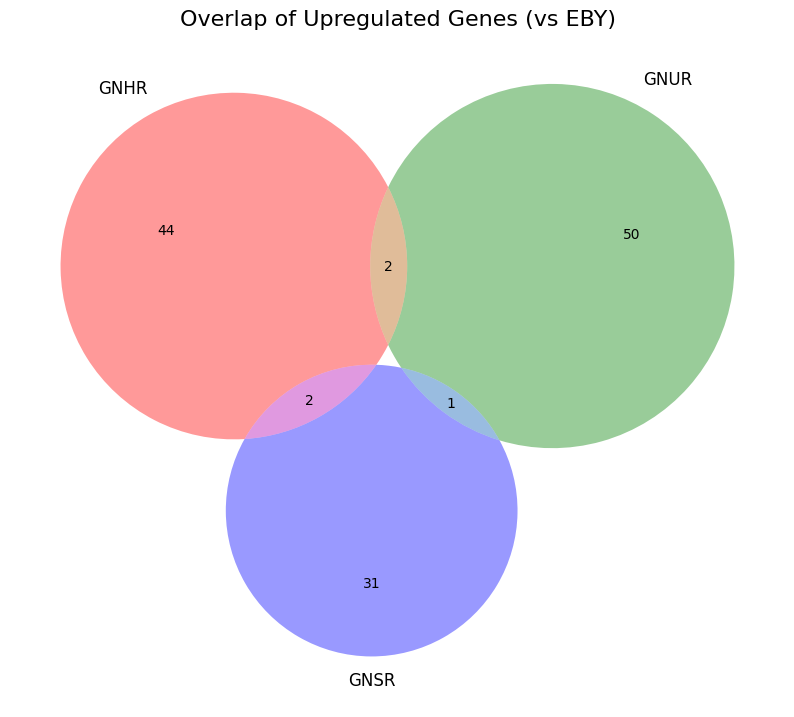

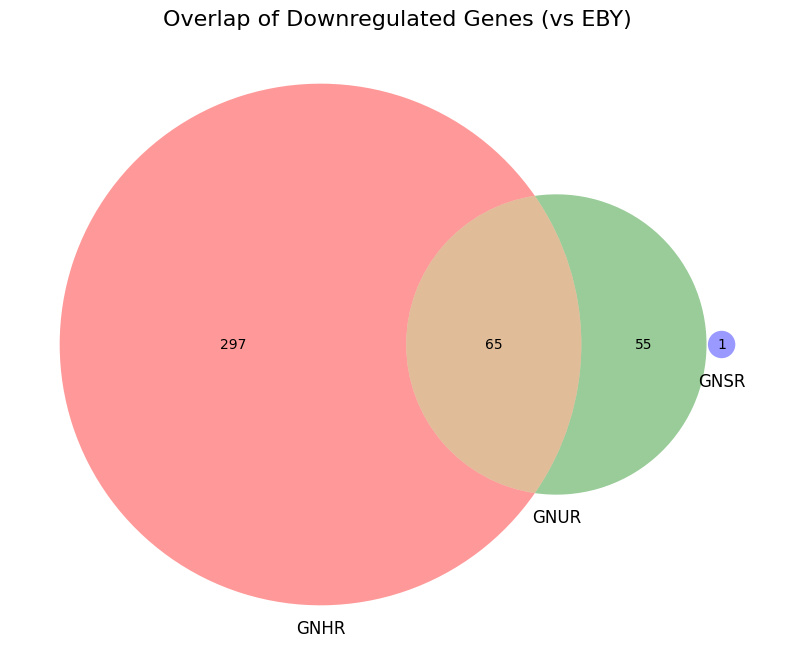

In [15]:
# --- 12. Create Venn Diagrams for Upregulated and Downregulated Genes ---

# Ensure the plotting libraries are still imported
try:
    from matplotlib_venn import venn3
    import matplotlib.pyplot as plt
except ImportError:
    print("Please install the 'matplotlib-venn' library first.")
    print("You can do this by running the command: pip install matplotlib-venn")
    exit()

# Define the comparisons
comparisons_venn = [('GNHR', 'EBY'), ('GNUR', 'EBY'), ('GNSR', 'EBY')]

# Dictionaries to hold the sets of gene IDs for each regulation type
upregulated_gene_sets = {}
downregulated_gene_sets = {}

print("--- Identifying Upregulated and Downregulated Gene Sets ---")

# Loop through each comparison to populate the dictionaries
for group1, group2 in comparisons_venn:
    # Calculate differential expression
    results_df = calculate_differential_expression(df, group1, group2)
    
    # Filter for significant genes first
    significant_genes = results_df[
        (results_df['pvalue'] < p_val_threshold_sig) &
        (abs(results_df['log2FoldChange']) > log2fc_threshold_sig)
    ]
    
    # --- Upregulated Genes ---
    upregulated_genes = significant_genes[significant_genes['log2FoldChange'] > log2fc_threshold_sig]
    upregulated_gene_sets[group1] = set(upregulated_genes['Geneid'])
    print(f"Found {len(upregulated_gene_sets[group1])} upregulated genes for {group1}")
    
    # --- Downregulated Genes ---
    downregulated_genes = significant_genes[significant_genes['log2FoldChange'] < -log2fc_threshold_sig]
    downregulated_gene_sets[group1] = set(downregulated_genes['Geneid'])
    print(f"Found {len(downregulated_gene_sets[group1])} downregulated genes for {group1}")

# --- Create the Venn Diagram for Upregulated Genes ---
plt.figure(figsize=(10, 10))
venn3(
    [upregulated_gene_sets['GNHR'], upregulated_gene_sets['GNUR'], upregulated_gene_sets['GNSR']],
    set_labels=('GNHR', 'GNUR', 'GNSR')
)
plt.title("Overlap of Upregulated Genes (vs EBY)", fontsize=16)
plt.show()

# --- Create the Venn Diagram for Downregulated Genes ---
plt.figure(figsize=(10, 10))
venn3(
    [downregulated_gene_sets['GNHR'], downregulated_gene_sets['GNUR'], downregulated_gene_sets['GNSR']],
    set_labels=('GNHR', 'GNUR', 'GNSR')
)
plt.title("Overlap of Downregulated Genes (vs EBY)", fontsize=16)
plt.show()

In [17]:
# --- 13. Create Interactive 3D Scatter Plots (Corrected) ---

print("--- Preparing data for 3D plots ---")

# A dictionary to hold the results for each comparison
results_collection = {}
comparisons_3d = [('GNHR', 'EBY'), ('GNUR', 'EBY'), ('GNSR', 'EBY')]

for group1, group2 in comparisons_3d:
    # Calculate DE and store the full result
    results_df = calculate_differential_expression(df, group1, group2)
    # Calculate -log10(pvalue), handling p=0 cases for plotting
    results_df['-log10(pvalue)'] = -np.log10(results_df['pvalue'].replace(0, 1e-300))
    results_collection[group1] = results_df.set_index('Geneid')

# Combine the results into a single DataFrame
plot_df = pd.concat([
    results_collection['GNHR'][['-log10(pvalue)', 'log2FoldChange']].add_suffix('_GNHR'),
    results_collection['GNUR'][['-log10(pvalue)', 'log2FoldChange']].add_suffix('_GNUR'),
    results_collection['GNSR'][['-log10(pvalue)', 'log2FoldChange']].add_suffix('_GNSR'),
], axis=1).reset_index()


# --- Part 1: Upregulated Genes Plot ---

# Define the conditions for being significantly upregulated in each strain (using the full dataframe)
is_up_gnhr = (plot_df['log2FoldChange_GNHR'] > log2fc_threshold_sig) & (plot_df['-log10(pvalue)_GNHR'] > -np.log10(p_val_threshold_sig))
is_up_gnur = (plot_df['log2FoldChange_GNUR'] > log2fc_threshold_sig) & (plot_df['-log10(pvalue)_GNUR'] > -np.log10(p_val_threshold_sig))
is_up_gnsr = (plot_df['log2FoldChange_GNSR'] > log2fc_threshold_sig) & (plot_df['-log10(pvalue)_GNSR'] > -np.log10(p_val_threshold_sig))

# Create a new DataFrame containing only genes upregulated in at least one strain
upregulated_df = plot_df[is_up_gnhr | is_up_gnur | is_up_gnsr].copy()

# **FIX**: Define color conditions *using the newly filtered upregulated_df*
up_cond_gnhr = (upregulated_df['log2FoldChange_GNHR'] > log2fc_threshold_sig) & (upregulated_df['-log10(pvalue)_GNHR'] > -np.log10(p_val_threshold_sig))
up_cond_gnur = (upregulated_df['log2FoldChange_GNUR'] > log2fc_threshold_sig) & (upregulated_df['-log10(pvalue)_GNUR'] > -np.log10(p_val_threshold_sig))
up_cond_gnsr = (upregulated_df['log2FoldChange_GNSR'] > log2fc_threshold_sig) & (upregulated_df['-log10(pvalue)_GNSR'] > -np.log10(p_val_threshold_sig))

conditions_up = [
    up_cond_gnsr & ~up_cond_gnur & ~up_cond_gnhr,
    up_cond_gnur & ~up_cond_gnsr & ~up_cond_gnhr,
    up_cond_gnhr & ~up_cond_gnsr & ~up_cond_gnur,
]
choices_up = ['Upregulated in GNSR only', 'Upregulated in GNUR only', 'Upregulated in GNHR only']
upregulated_df['Regulation'] = np.select(conditions_up, choices_up, default='Upregulated in Multiple Strains')

# Create the 3D scatter plot
fig_up = px.scatter_3d(
    upregulated_df,
    x='-log10(pvalue)_GNHR', y='-log10(pvalue)_GNUR', z='-log10(pvalue)_GNSR',
    color='Regulation', hover_data=['Geneid'], title='Upregulated Genes Significance',
    labels={'x': 'GNHR -log10(p-value)', 'y': 'GNUR -log10(p-value)', 'z': 'GNSR -log10(p-value)'},
    color_discrete_map={
        'Upregulated in GNSR only': 'red', 'Upregulated in GNUR only': 'green',
        'Upregulated in GNHR only': 'purple', 'Upregulated in Multiple Strains': 'grey'
    }
)
fig_up.write_html("upregulated_3d_plot.html")
print("✅ Successfully created 'upregulated_3d_plot.html'")


# --- Part 2: Downregulated Genes Plot ---

# Define conditions for being significantly downregulated (using the full dataframe)
is_down_gnhr = (plot_df['log2FoldChange_GNHR'] < -log2fc_threshold_sig) & (plot_df['-log10(pvalue)_GNHR'] > -np.log10(p_val_threshold_sig))
is_down_gnur = (plot_df['log2FoldChange_GNUR'] < -log2fc_threshold_sig) & (plot_df['-log10(pvalue)_GNUR'] > -np.log10(p_val_threshold_sig))
is_down_gnsr = (plot_df['log2FoldChange_GNSR'] < -log2fc_threshold_sig) & (plot_df['-log10(pvalue)_GNSR'] > -np.log10(p_val_threshold_sig))

# Create a new DataFrame containing only genes downregulated in at least one strain
downregulated_df = plot_df[is_down_gnhr | is_down_gnur | is_down_gnsr].copy()

# **FIX**: Define color conditions *using the newly filtered downregulated_df*
down_cond_gnhr = (downregulated_df['log2FoldChange_GNHR'] < -log2fc_threshold_sig) & (downregulated_df['-log10(pvalue)_GNHR'] > -np.log10(p_val_threshold_sig))
down_cond_gnur = (downregulated_df['log2FoldChange_GNUR'] < -log2fc_threshold_sig) & (downregulated_df['-log10(pvalue)_GNUR'] > -np.log10(p_val_threshold_sig))
down_cond_gnsr = (downregulated_df['log2FoldChange_GNSR'] < -log2fc_threshold_sig) & (downregulated_df['-log10(pvalue)_GNSR'] > -np.log10(p_val_threshold_sig))

conditions_down = [
    down_cond_gnsr & ~down_cond_gnur & ~down_cond_gnhr,
    down_cond_gnur & ~down_cond_gnsr & ~down_cond_gnhr,
    down_cond_gnhr & ~down_cond_gnsr & ~down_cond_gnur,
]
choices_down = ['Downregulated in GNSR only', 'Downregulated in GNUR only', 'Downregulated in GNHR only']
downregulated_df['Regulation'] = np.select(conditions_down, choices_down, default='Downregulated in Multiple Strains')

# Create the 3D scatter plot
fig_down = px.scatter_3d(
    downregulated_df,
    x='-log10(pvalue)_GNHR', y='-log10(pvalue)_GNUR', z='-log10(pvalue)_GNSR',
    color='Regulation', hover_data=['Geneid'], title='Downregulated Genes Significance',
    labels={'x': 'GNHR -log10(p-value)', 'y': 'GNUR -log10(p-value)', 'z': 'GNSR -log10(p-value)'},
    color_discrete_map={
        'Downregulated in GNSR only': 'red', 'Downregulated in GNUR only': 'green',
        'Downregulated in GNHR only': 'purple', 'Downregulated in Multiple Strains': 'grey'
    }
)
fig_down.write_html("downregulated_3d_plot.html")
print("✅ Successfully created 'downregulated_3d_plot.html'")

--- Preparing data for 3D plots ---


/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


✅ Successfully created 'upregulated_3d_plot.html'
✅ Successfully created 'downregulated_3d_plot.html'


In [21]:
# --- 14. Create Interactive Ternary Plots (Corrected) ---

print("--- Preparing data for Ternary plots ---")

# --- Part 1: Upregulated Genes Ternary Plot ---

# We'll use the 'upregulated_df' created in the previous step.
# Calculate the sum of -log10(p-values) for normalization
p_sum_up = upregulated_df['-log10(pvalue)_GNHR'] + upregulated_df['-log10(pvalue)_GNUR'] + upregulated_df['-log10(pvalue)_GNSR']

# Avoid division by zero for genes with no significance
p_sum_up = p_sum_up.replace(0, 1)

# Create the ternary plot
fig_up_ternary = go.Figure(go.Scatterternary({
    'a': upregulated_df['-log10(pvalue)_GNHR'] / p_sum_up,
    'b': upregulated_df['-log10(pvalue)_GNUR'] / p_sum_up,
    'c': upregulated_df['-log10(pvalue)_GNSR'] / p_sum_up,
    'mode': 'markers',
    'hovertext': upregulated_df['Geneid'] + '<br>' + upregulated_df['Regulation'],
    'marker': {
        'color': upregulated_df['Regulation'].map({
            'Upregulated in GNSR only': 'red',
            'Upregulated in GNUR only': 'green',
            'Upregulated in GNHR only': 'purple',
            'Upregulated in Multiple Strains': 'grey'
        }),
        'size': 8,
        'opacity': 0.7
    }
}))

# FIX: Removed the 'min' property from the axis definitions
fig_up_ternary.update_layout({
    'title': 'Relative Significance of Upregulated Genes',
    'ternary': {
        'sum': 1,
        'aaxis': {'title': 'GNHR', 'linewidth': 2, 'ticks': 'outside'},
        'baxis': {'title': 'GNUR', 'linewidth': 2, 'ticks': 'outside'},
        'caxis': {'title': 'GNSR', 'linewidth': 2, 'ticks': 'outside'},
    },
    'showlegend': False
})

fig_up_ternary.write_html("upregulated_ternary_plot.html")
print("✅ Successfully created 'upregulated_ternary_plot.html'")


# --- Part 2: Downregulated Genes Ternary Plot ---

# We'll use the 'downregulated_df' created in the previous step.
# Calculate the sum of -log10(p-values) for normalization
p_sum_down = downregulated_df['-log10(pvalue)_GNHR'] + downregulated_df['-log10(pvalue)_GNUR'] + downregulated_df['-log10(pvalue)_GNSR']

# Avoid division by zero
p_sum_down = p_sum_down.replace(0, 1)

# Create the ternary plot
fig_down_ternary = go.Figure(go.Scatterternary({
    'a': downregulated_df['-log10(pvalue)_GNHR'] / p_sum_down,
    'b': downregulated_df['-log10(pvalue)_GNUR'] / p_sum_down,
    'c': downregulated_df['-log10(pvalue)_GNSR'] / p_sum_down,
    'mode': 'markers',
    'hovertext': downregulated_df['Geneid'] + '<br>' + downregulated_df['Regulation'],
    'marker': {
        'color': downregulated_df['Regulation'].map({
            'Downregulated in GNSR only': 'red',
            'Downregulated in GNUR only': 'green',
            'Downregulated in GNHR only': 'purple',
            'Downregulated in Multiple Strains': 'grey'
        }),
        'size': 8,
        'opacity': 0.7
    }
}))

# FIX: Removed the 'min' property from the axis definitions
fig_down_ternary.update_layout({
    'title': 'Relative Significance of Downregulated Genes',
    'ternary': {
        'sum': 1,
        'aaxis': {'title': 'GNHR', 'linewidth': 2, 'ticks': 'outside'},
        'baxis': {'title': 'GNUR', 'linewidth': 2, 'ticks': 'outside'},
        'caxis': {'title': 'GNSR', 'linewidth': 2, 'ticks': 'outside'},
    },
    'showlegend': False
})

fig_down_ternary.write_html("downregulated_ternary_plot.html")
print("✅ Successfully created 'downregulated_ternary_plot.html'")

--- Preparing data for Ternary plots ---
✅ Successfully created 'upregulated_ternary_plot.html'
✅ Successfully created 'downregulated_ternary_plot.html'
